In [1]:
#Import libraries
import ee
import geemap

In [ ]:
ee.Authenticate()

In [2]:
#initialisation of earth engine
ee.Initialize()


In [3]:
#import area of interest
Map=geemap.Map()
delhi_shp = '*/india_state/delhi/delhi_boun.shp'
aoi = geemap.shp_to_ee(delhi_shp)
Map.addLayer(aoi, {}, 'boundary')
Map.centerObject(aoi,10)
Map

Map(center=[28.643320532058556, 77.11550454321808], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
#Image collection , NDVI and NDWI calculation 
#export the composite, NDVI and NDWI
sentinel2= ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
    .filterDate('2015-12-01', '2015-12-31')\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20))\#<5% cloud cover image is not available for 2015, for other year <5% cloud cover has been used
    .filterBounds(aoi)
    #.first()

composite = sentinel2.max().select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12'])\
    .clip(aoi)

fcc={'bands': ['B8', 'B4', 'B3'], 'min':0, 'max':3000}
Map.addLayer(composite, fcc,"Sentinel RGB")
ndvi = composite.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndviViz = {'min': -1, 'max': 1, 'palette': ['#cbf078', '#e46161','#f7e185','#f83e4b']}
#ndviViz = {'min': 0, 'max': 1, 'palette':['#d73027', '#f46d43', '#fdae61', '#fee08b', '#d9ef8b', '#a6d96a']}
Map.addLayer(ndvi, ndviViz, 'NDVI', False)
ndwi = composite.normalizedDifference(['B8', 'B12']).rename('NDWI')
ndwiViz = {'min': -1, 'max': 0.5, 'palette': ['#df0e62','#fac70b','#127681','#21174a']}
Map.addLayer(ndwi, ndwiViz, 'NDWI', False)

task = ee.batch.Export.image.toDrive(image=composite,
                                     description='composite2015',
                                     scale=10,
                                     region=aoi.geometry(),
                                     fileNamePrefix='delhi2015',
                                     folder='**',
                                     crs='EPSG:4326',
                                     fileFormat='GeoTIFF')
task.start()
task = ee.batch.Export.image.toDrive(image=ndvi,
                                     description='ndvi2015',
                                     scale=10,
                                     region=aoi.geometry(),
                                     fileNamePrefix='ndvi2015',
                                     folder='**',
                                     crs='EPSG:4326',
                                     fileFormat='GeoTIFF')
task.start()

task = ee.batch.Export.image.toDrive(image=ndwi,
                                     description='ndwi2015',
                                     scale=10,
                                     region=aoi.geometry(),
                                     fileNamePrefix='ndwi2015',
                                     folder='**',
                                     crs='EPSG:4326',
                                     fileFormat='GeoTIFF')
task.start()

Now the NDVI and NDWI images are downloaded from the google drive and analyse the NDVI and NDWI

In [4]:
#Import the libraries
import os
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
import rasterstats
import matplotlib.pyplot as plt
import pandas as pd

   Year      NDVI
0  2015  0.106411
1  2016  0.211230
2  2017  0.150455
3  2018  0.185650
4  2019  0.195045
5  2020  0.164600
6  2021  0.150317
7  2022  0.106411


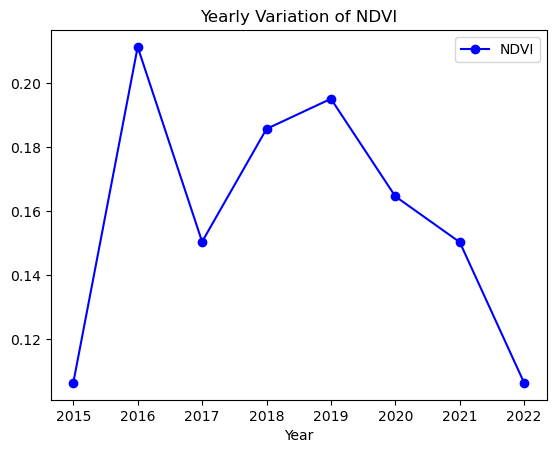

In [5]:
#spatial averaging of NDVI and plotting yearly NDVI 
dirname = '*/ndvi1'
delhi=gpd.read_file('*/india_state/delhi/delhi_boun.shp')
vi_mean = []
for fname in os.listdir(dirname):
    im = rasterio.open(os.path.join(dirname, fname))
    im_array = im.read(1)
    affine = im.transform
    avg_ndvi  = rasterstats.zonal_stats(delhi, im_array, affine = affine,
                                      stats = ['mean'], 
                                      geojson_out = True)
    avg_ndvi=avg_ndvi[0]['properties']
    avg_ndvi=avg_ndvi.get('mean')
    eer=[fname[4:8],avg_ndvi]
    vi_mean.append(eer)

ndvi_df = pd.DataFrame.from_dict(vi_mean)
ndvi_df.columns= ['Year', 'NDVI']
print(ndvi_df)
fig=ndvi_df.plot.line(x = 'Year', y = 'NDVI', c = 'blue',style=['o-'], title='Yearly Variation of NDVI' ).get_figure()#plot.scatter
fig.savefig('*/scatterndvi.png', dpi=300)

   Year      NDWI
0  2015  0.216350
1  2016  0.189754
2  2017  0.211378
3  2018  0.231257
4  2019  0.224950
5  2020  0.226706
6  2021  0.285184
7  2022  0.249489


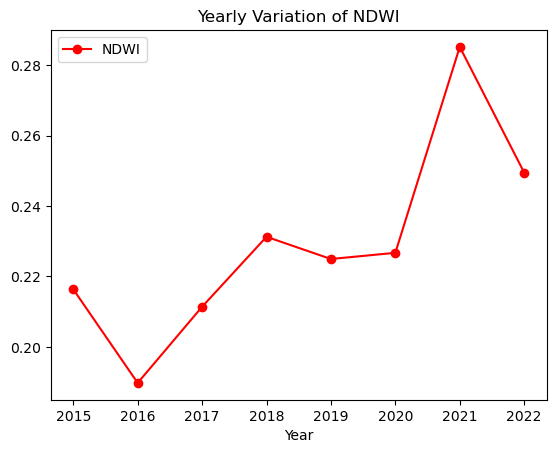

In [6]:
#spatial averaging of NDWI and plotting yearly NDWI 
dirname = '*/ndwi1'
wi_mean = []
for fname in os.listdir(dirname):
    im = rasterio.open(os.path.join(dirname, fname))
    im_array = im.read(1)
    affine=im.transform
    avg_ndwi  = rasterstats.zonal_stats(delhi, im_array, affine = affine,
                                      stats = ['mean'], 
                                      geojson_out = True)
    avg_ndwi=avg_ndwi[0]['properties']
    avg_ndwi=avg_ndwi.get('mean')
    eer=[fname[4:8],avg_ndwi]
    wi_mean.append(eer)

ndwi_df = pd.DataFrame.from_dict(wi_mean)
ndwi_df.columns= ['Year', 'NDWI']
print(ndwi_df)
fig=ndwi_df.plot.line(x = 'Year', y = 'NDWI', c = 'red',style=['o-'], title='Yearly Variation of NDWI' ).get_figure()#plot.scatter
fig.savefig('*/scatterndwi1.png', dpi=300)

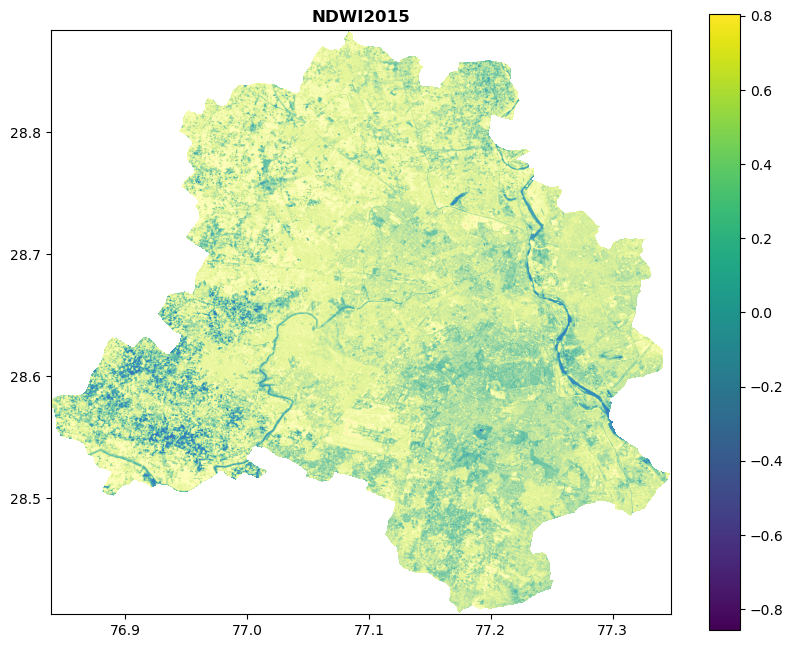

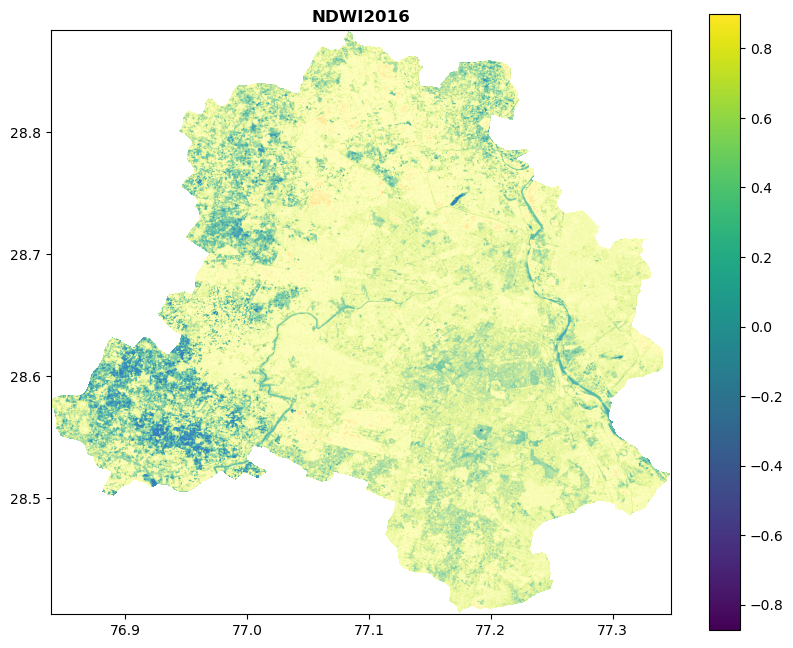

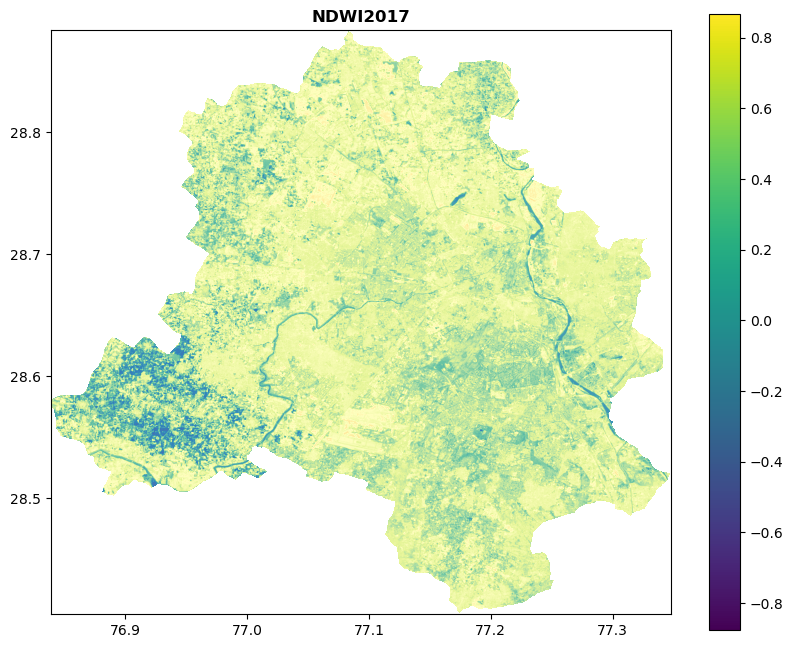

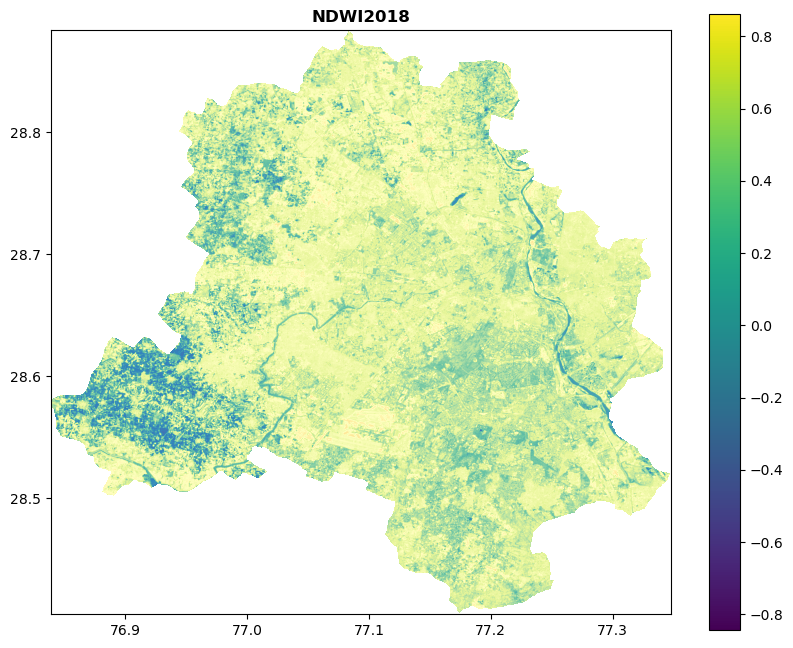

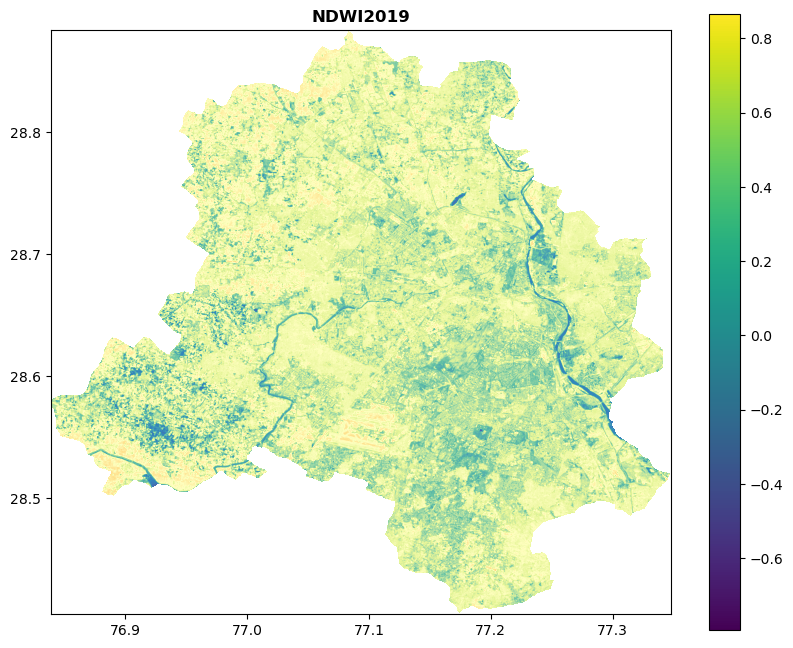

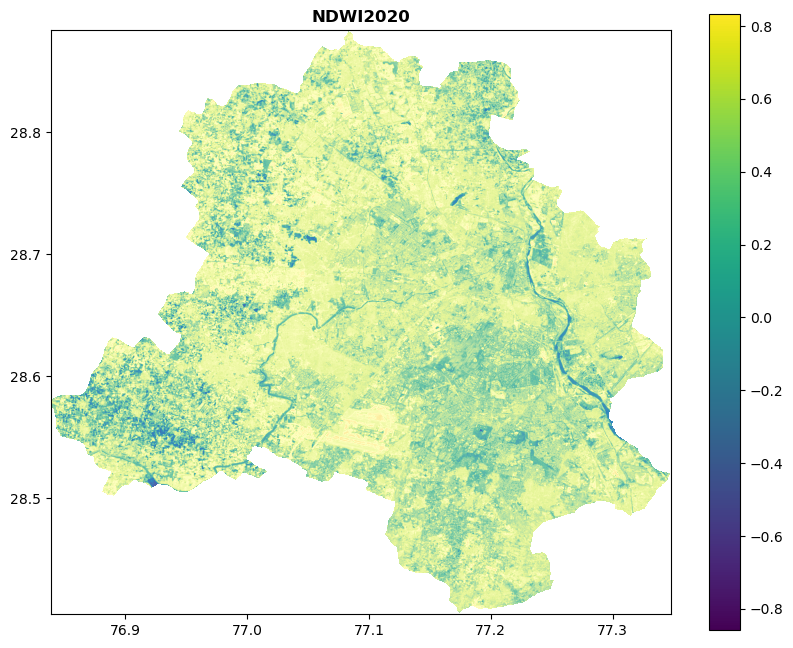

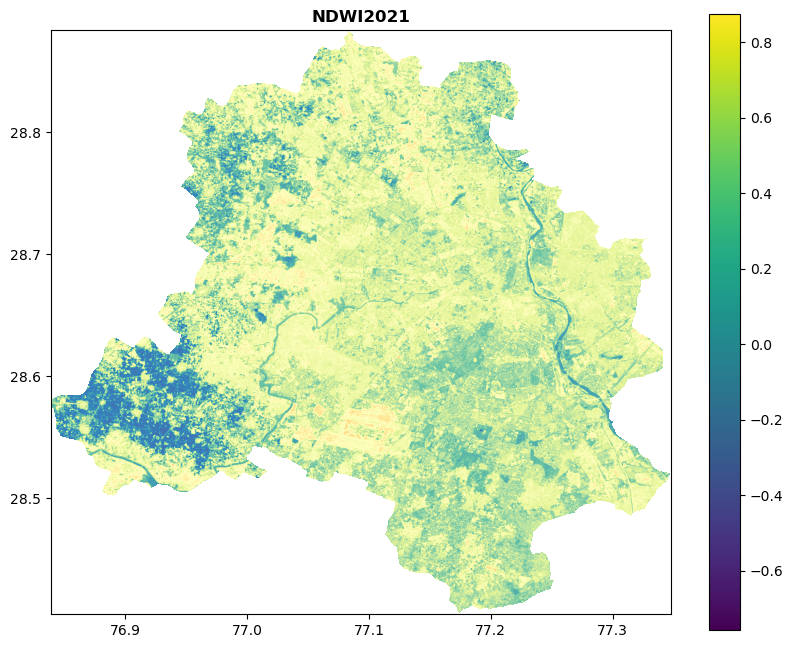

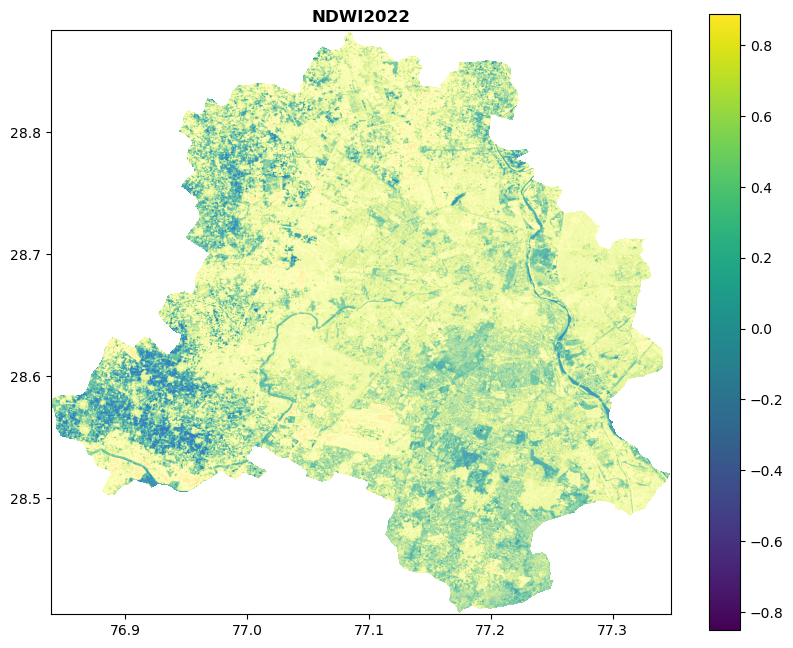

In [27]:
#map layout of NDWI for different year
dirname = '*/ndwi1'
for fname in os.listdir(dirname):
    im = rasterio.open(os.path.join(dirname, fname))
    year=fname[4:8]
    #fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,8))
    fig, (ax) = plt.subplots(figsize = (10,8))
    show(im, ax = ax, title = 'NDWI'+ year)
    #delhi.plot(ax = ax1, facecolor = 'None', edgecolor = 'black')
    #show_hist(im, title = 'Histogram', ax = ax2)

    retted = rasterio.plot.show(im, ax=ax, cmap='Spectral') 
    im = retted.get_images()[0]
    fig.colorbar(im, ax=ax)
    plt.savefig('*/'+ fname[0:8] +'.png', dpi=300)
    plt.show()

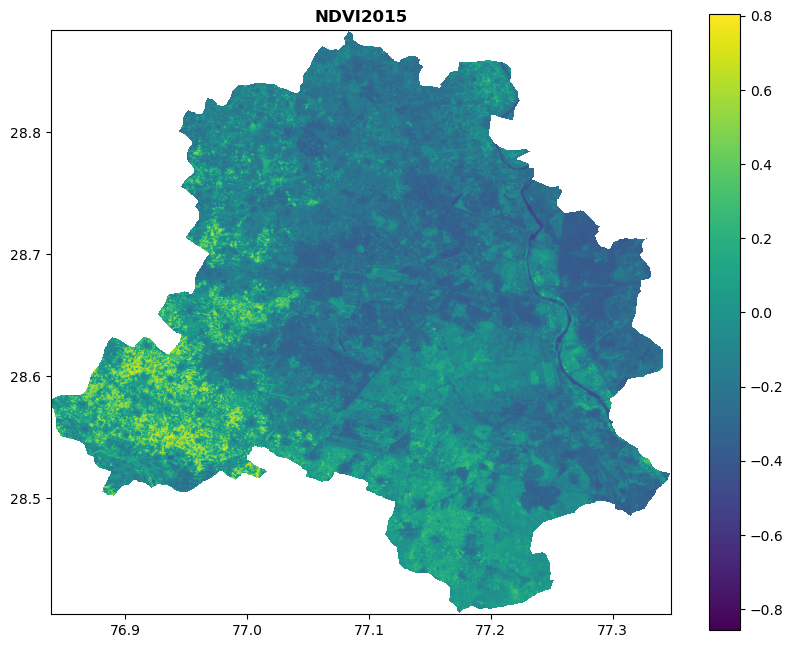

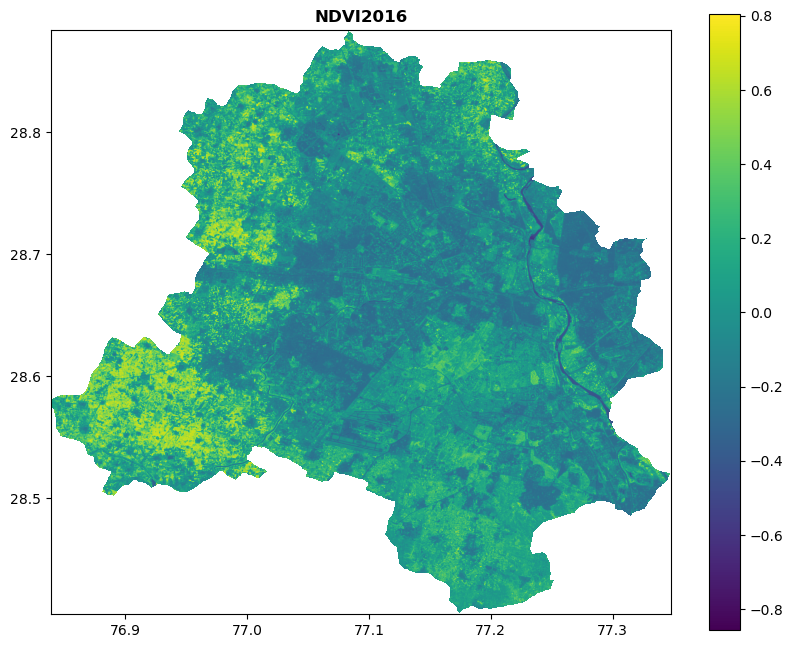

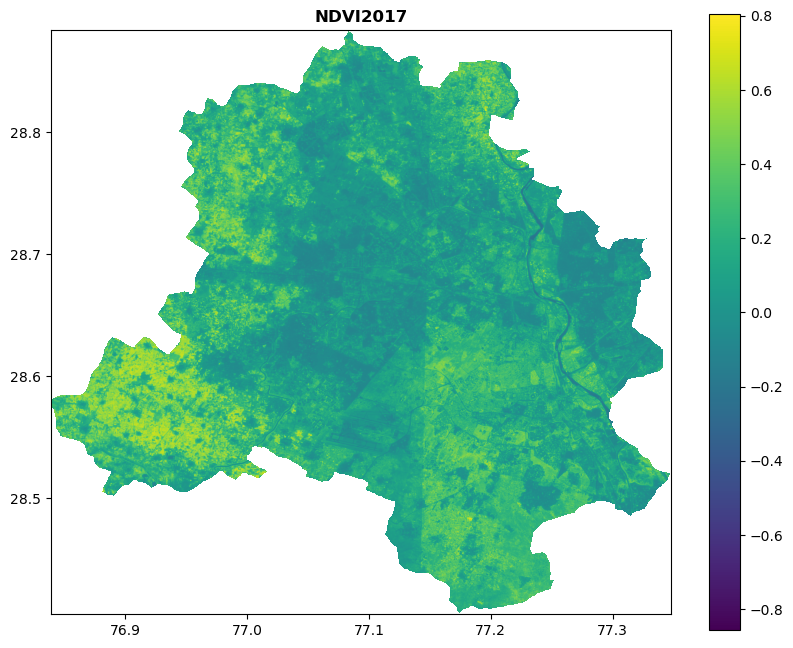

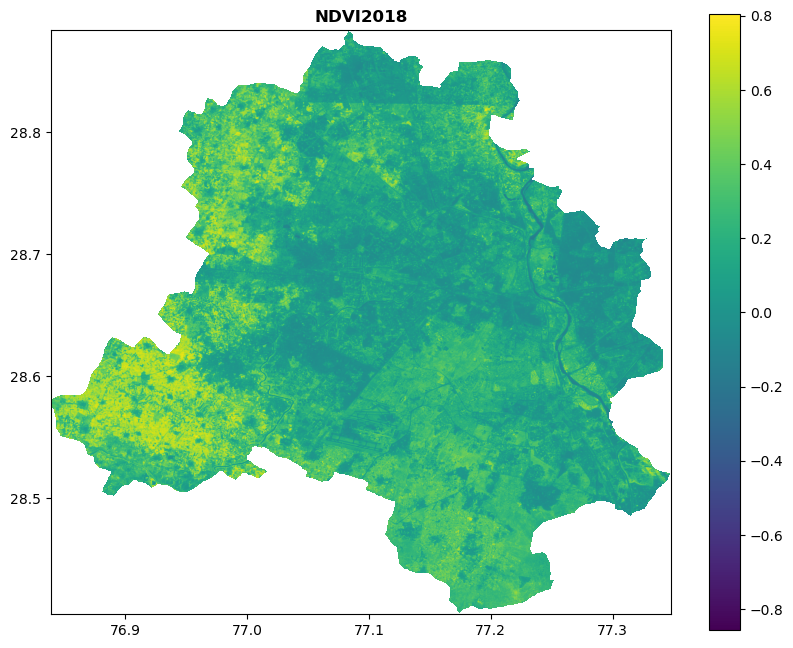

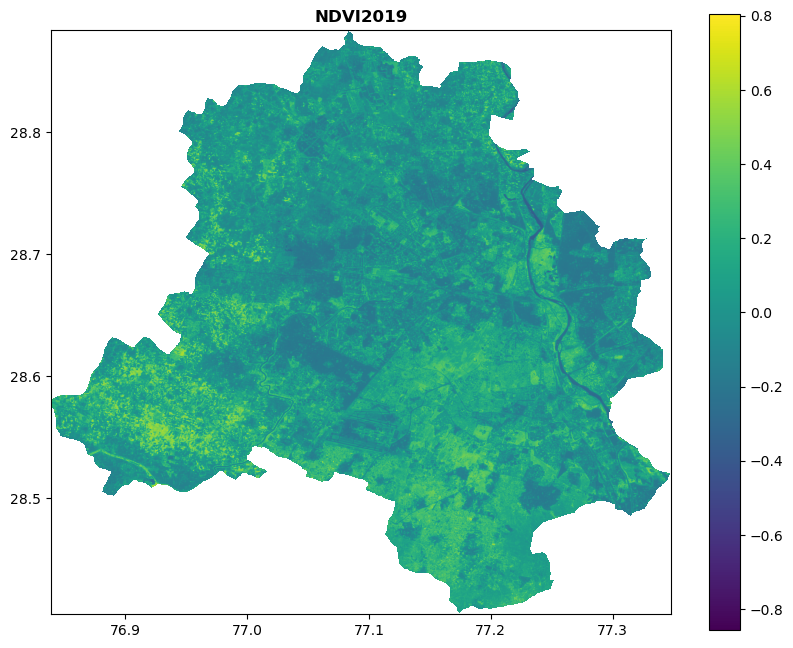

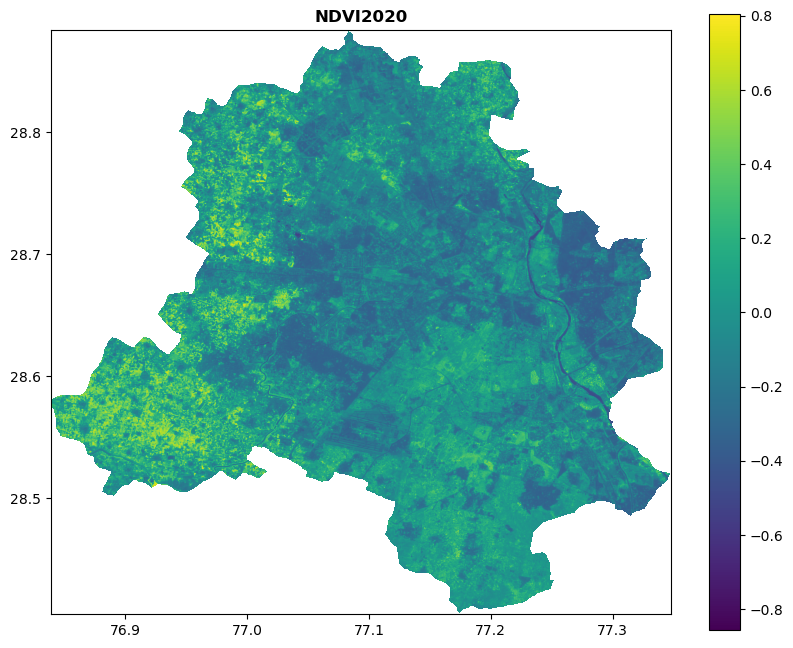

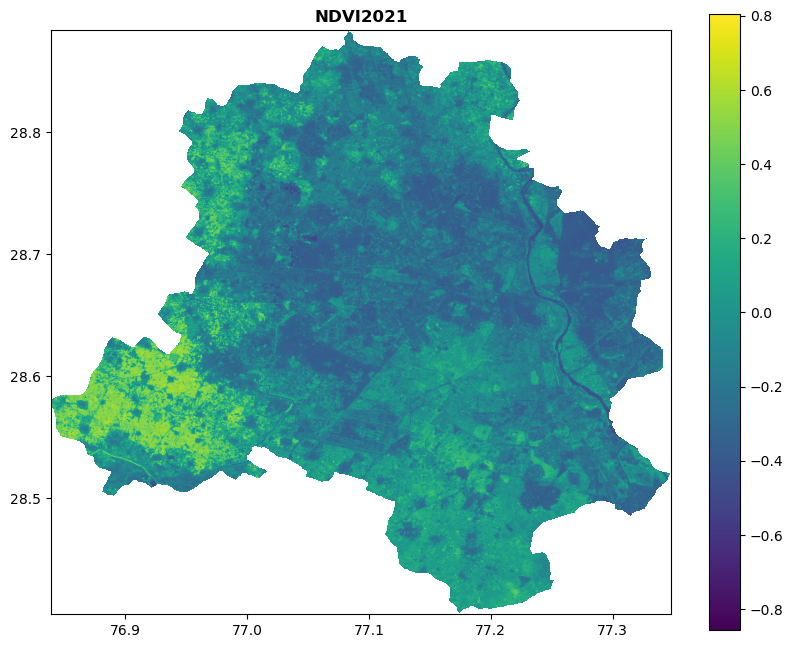

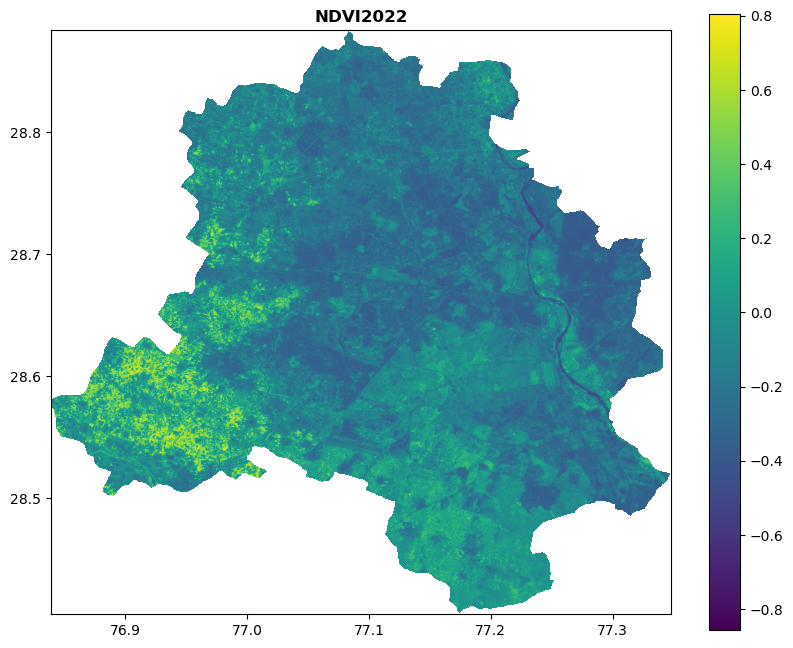

In [22]:
#Map layout of NDVI for different year
dirname = '*/ndvi1'

for fname in os.listdir(dirname):
    im = rasterio.open(os.path.join(dirname, fname))
    year=fname[4:8]
    fig, (ax) = plt.subplots(figsize = (10,8))
    show(im, ax = ax, title = 'NDVI'+ year)
    #delhi.plot(ax = ax1, facecolor = 'None', edgecolor = 'black')
    #show_hist(ndvi, title = 'Histogram', ax = ax2)

    retted = rasterio.plot.show(im, ax=ax1, cmap='Spectral') 
    im = retted.get_images()[0]
    fig.colorbar(im, ax=ax)
    plt.savefig('*/'+ fname[0:8] +'.png', dpi=300)
    plt.show()